# T<sub>2</sub><sup>\*</sup> Variations

> 5/17/19

This document records the T<sub>2</sub><sup>\*</sup> variations between qubits. Apparently, this is the actual decoherence time/Ramsey experiment, **not** the T<sub>2</sub> time. This is explained [here](https://quantumcomputing.stackexchange.com/questions/2432/whats-the-difference-between-t2-and-t2).

In [1]:
# import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.ignis.characterization.coherence as ig
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

In [2]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5, backend=None, opt=True):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [3]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

Now we can use the Qiskit Ignis `t2star` circuit generator to create the correct circuits. We will do this separately for each qubit because we want higher data resolution without exceeding the allowable payload size.

In [6]:
# get least busy backend to keep consistent
available = q.IBMQ.backends(filters=lambda x:
                            x.configuration().n_qubits >= 1
                            and not
                            x.configuration().simulator)
backend = q.providers.ibmq.least_busy(available)

delays = np.arange(0, 500, 25)
gt = 0.08333  # gate timing in microseconds, from a sketchy old forum post

job_ids = []
freqs = []
for i in range(5):
    # test one qubit at a time to avoid too large a payload
    circuits, _, freq = ig.circuits.t2star_circuits(num_of_gates=delays, gate_time=gt, qubits=[i], nosc=5)
    job, backend, _ = run(circuits, backend=backend)
    job_ids += [job.job_id()]
    freqs += [freq]
print('\nfrequency list: ', freqs)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdf0f0324773d006b42fef6'
Ran on backend 'ibmqx4'
Completed 2019-05-17T19:44:02.786Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdf0f7c74321e007233fa0e'
Ran on backend 'ibmqx4'
Completed 2019-05-17T19:46:04.246Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdf0fdfc692ab0076833865'
Ran on backend 'ibmqx4'
Completed 2019-05-17T19:47:43.209Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdf10419a76660078b821af'
Ran on backend 'ibmqx4'
Completed 2019-05-17T19:49:21.554Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdf10a7c692ab0076833869'
Ran on backend 'ibmqx4'
Completed 2019-05-17T19:51:03.686Z

frequency list:  [0.1263208423073765, 0.1263208423073765, 0.1263208423073765, 0.1263208423073765, 0.1263208423073765]


We'll analyze each run with the help of a short little function to count the ground state population and standard error:

In [7]:
def count_results(result, circuits, shots=1024):
    freq = []    # frequency of '0' state
    stderr = []  # standard error

    for c in circuits:
        trial = Counter(result.get_counts(c))
        p = trial['0'] / shots
        freq += [p]
        stderr += [np.sqrt(p * (1 - p) / shots)]
    return freq, stderr

The main analysis function will fit the data to a damped oscillation model to determine the decay time constant:

In [13]:
from scipy.optimize import curve_fit

def damped_cos(t, a, b, c, d, e):
    # fully parameterized damped oscillation model
    return a * np.exp(-t / b) * np.cos(2 * np.pi * c * t + d) + e

def fit_model(delays, p, freq, stderr):
    # fits the model from:
    #   delays: the x-data (idle durations)
    #   p: the frequencies of the ground state measurement, from count_results
    #   freq: the induced qubit frequency (frequency of the oscillations)
    #   stderr: standard error in p
    params = curve_fit(damped_cos, delays, p, p0=[1, 30, freq, 0, 0.5],
                       bounds=([-0.5,  0,                0, -np.pi, -0.5],
                               [ 1.5, 40, 2 * np.pi * freq,  np.pi,  1.5]),
                       sigma=stderr)[0]
    return tuple(params)

We can now retrieve each experiment by its job ID for easier reproducibility and run some analysis to determine the decay time constant:

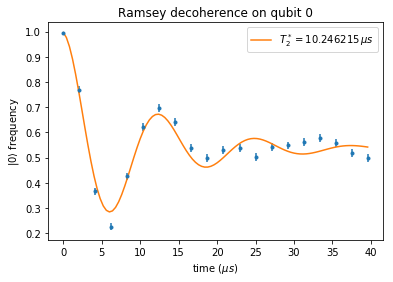

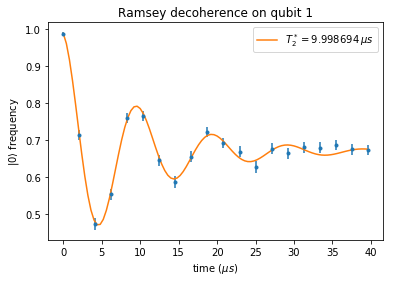

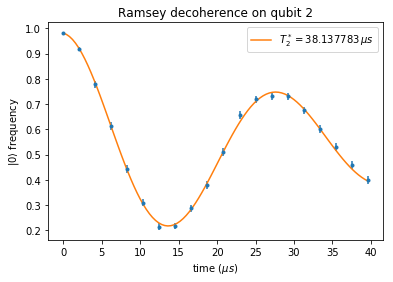

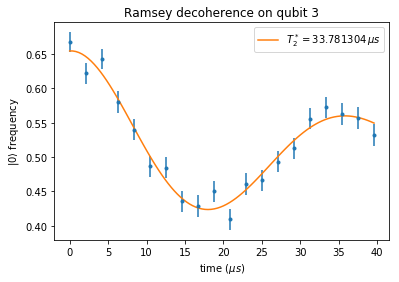

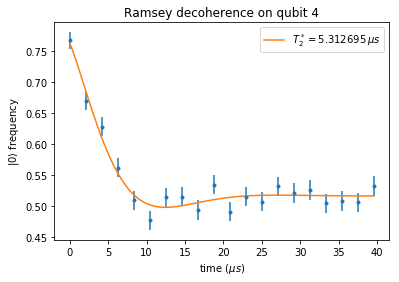

In [15]:
job_ids = ['5cdf0f0324773d006b42fef6',
           '5cdf0f7c74321e007233fa0e',
           '5cdf0fdfc692ab0076833865',
           '5cdf10419a76660078b821af',
           '5cdf10a7c692ab0076833869']

gt = 0.08333                           # gate time, microseconds
delays = np.arange(0, 500, 25) * gt    # idle durations
freq = 0.1263208423073765              # oscillation frequency
xs = np.linspace(0, max(delays), 100)  # continuous domain (for plotting)

# go through each qubit and plot 
for i, job_id in enumerate(job_ids):
    # retrieve job and run analysis with helper functions
    job = get_job(job_id, 'ibmqx4')
    p, s = count_results(job.result(), circuits)
    params = fit_model(delays, p, freq, s)
    
    # plot the analysis results
    fig, ax = plt.subplots()
    ax.errorbar(delays, p, s, linestyle='None', marker='.')
    ax.plot(xs, damped_cos(xs, *params), label=r'$T_2^* = %f\,\mu s$' % params[1])
    
    # prettify the plots
    ax.legend()
    ax.set_xlabel(r'time ($\mu s$)')
    ax.set_ylabel(r'$\vert 0 \rangle$ frequency')
    ax.set_title('Ramsey decoherence on qubit %d' % i)

Interestingly, the oscillations are not nearly as nice as when I ran q<sub>0</sub> by itself in `Ignis_T2_Tests.ipynb`, even though the code should be exactly the same. Maybe it's a backend difference, as I was using the Yorktown that time. I'm not sure why I don't get 5 cycles here, as specified in the circuit generator function. At any rate, here is a summary of the results for T<sub>2</sub><sup>\*</sup> measurements on the IBM Tenerife:

| Statistic | Q<sub>0</sub> | Q<sub>1</sub> | Q<sub>2</sub> | Q<sub>3</sub> | Q<sub>4</sub> |
|---|---|---|---|---|---|
| Experimental T<sub>2</sub> (&mu;s) | 10.246 | 9.999 | 38.138 | 33.781 | 5.313 |
| Expected T<sub>2</sub> (&mu;s) | 20.60 | 10.60 | 35.60 | 29.70 | 5.00 |
| Percent Error | -50.26 | -5.67 | +7.13 | +13.74 | +6.26 |

Most of these points are very good! The difference in q<sub>3</sub> can probably be explained by the high readout error (currently sitting at 0.3310). Even though our graphs are pretty ugly, the data seem to be about right&mdash;except for q<sub>0</sub>, which I'm at a loss to explain. It could just be the curve fitting; after all, it looks like the fitted cosine starts to get out of phase toward the end.

Also, keep in mind that these points use a rather sketchy value for the gate timing. The slightly lower value suggested by the Github file (which I'm not using because I'm not sure I fully understand it) would make qubits 2-4 even better.

(Actually, our fit for q<sub>4</sub> seems particularly bad/ignoring the oscillations, but the decay part seems to be about right, and that's the part we really care about.)

Just because it looks so pretty, here's what my old plot for q<sub>0</sub> on the Yorktown looks like:

![Yorktown T2 pretty](img/t2_very_pretty.png)